In [383]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [384]:
df = pd.read_csv(r'C:\Users\Felipe\Pictures\diabetes_analysis\diabetes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


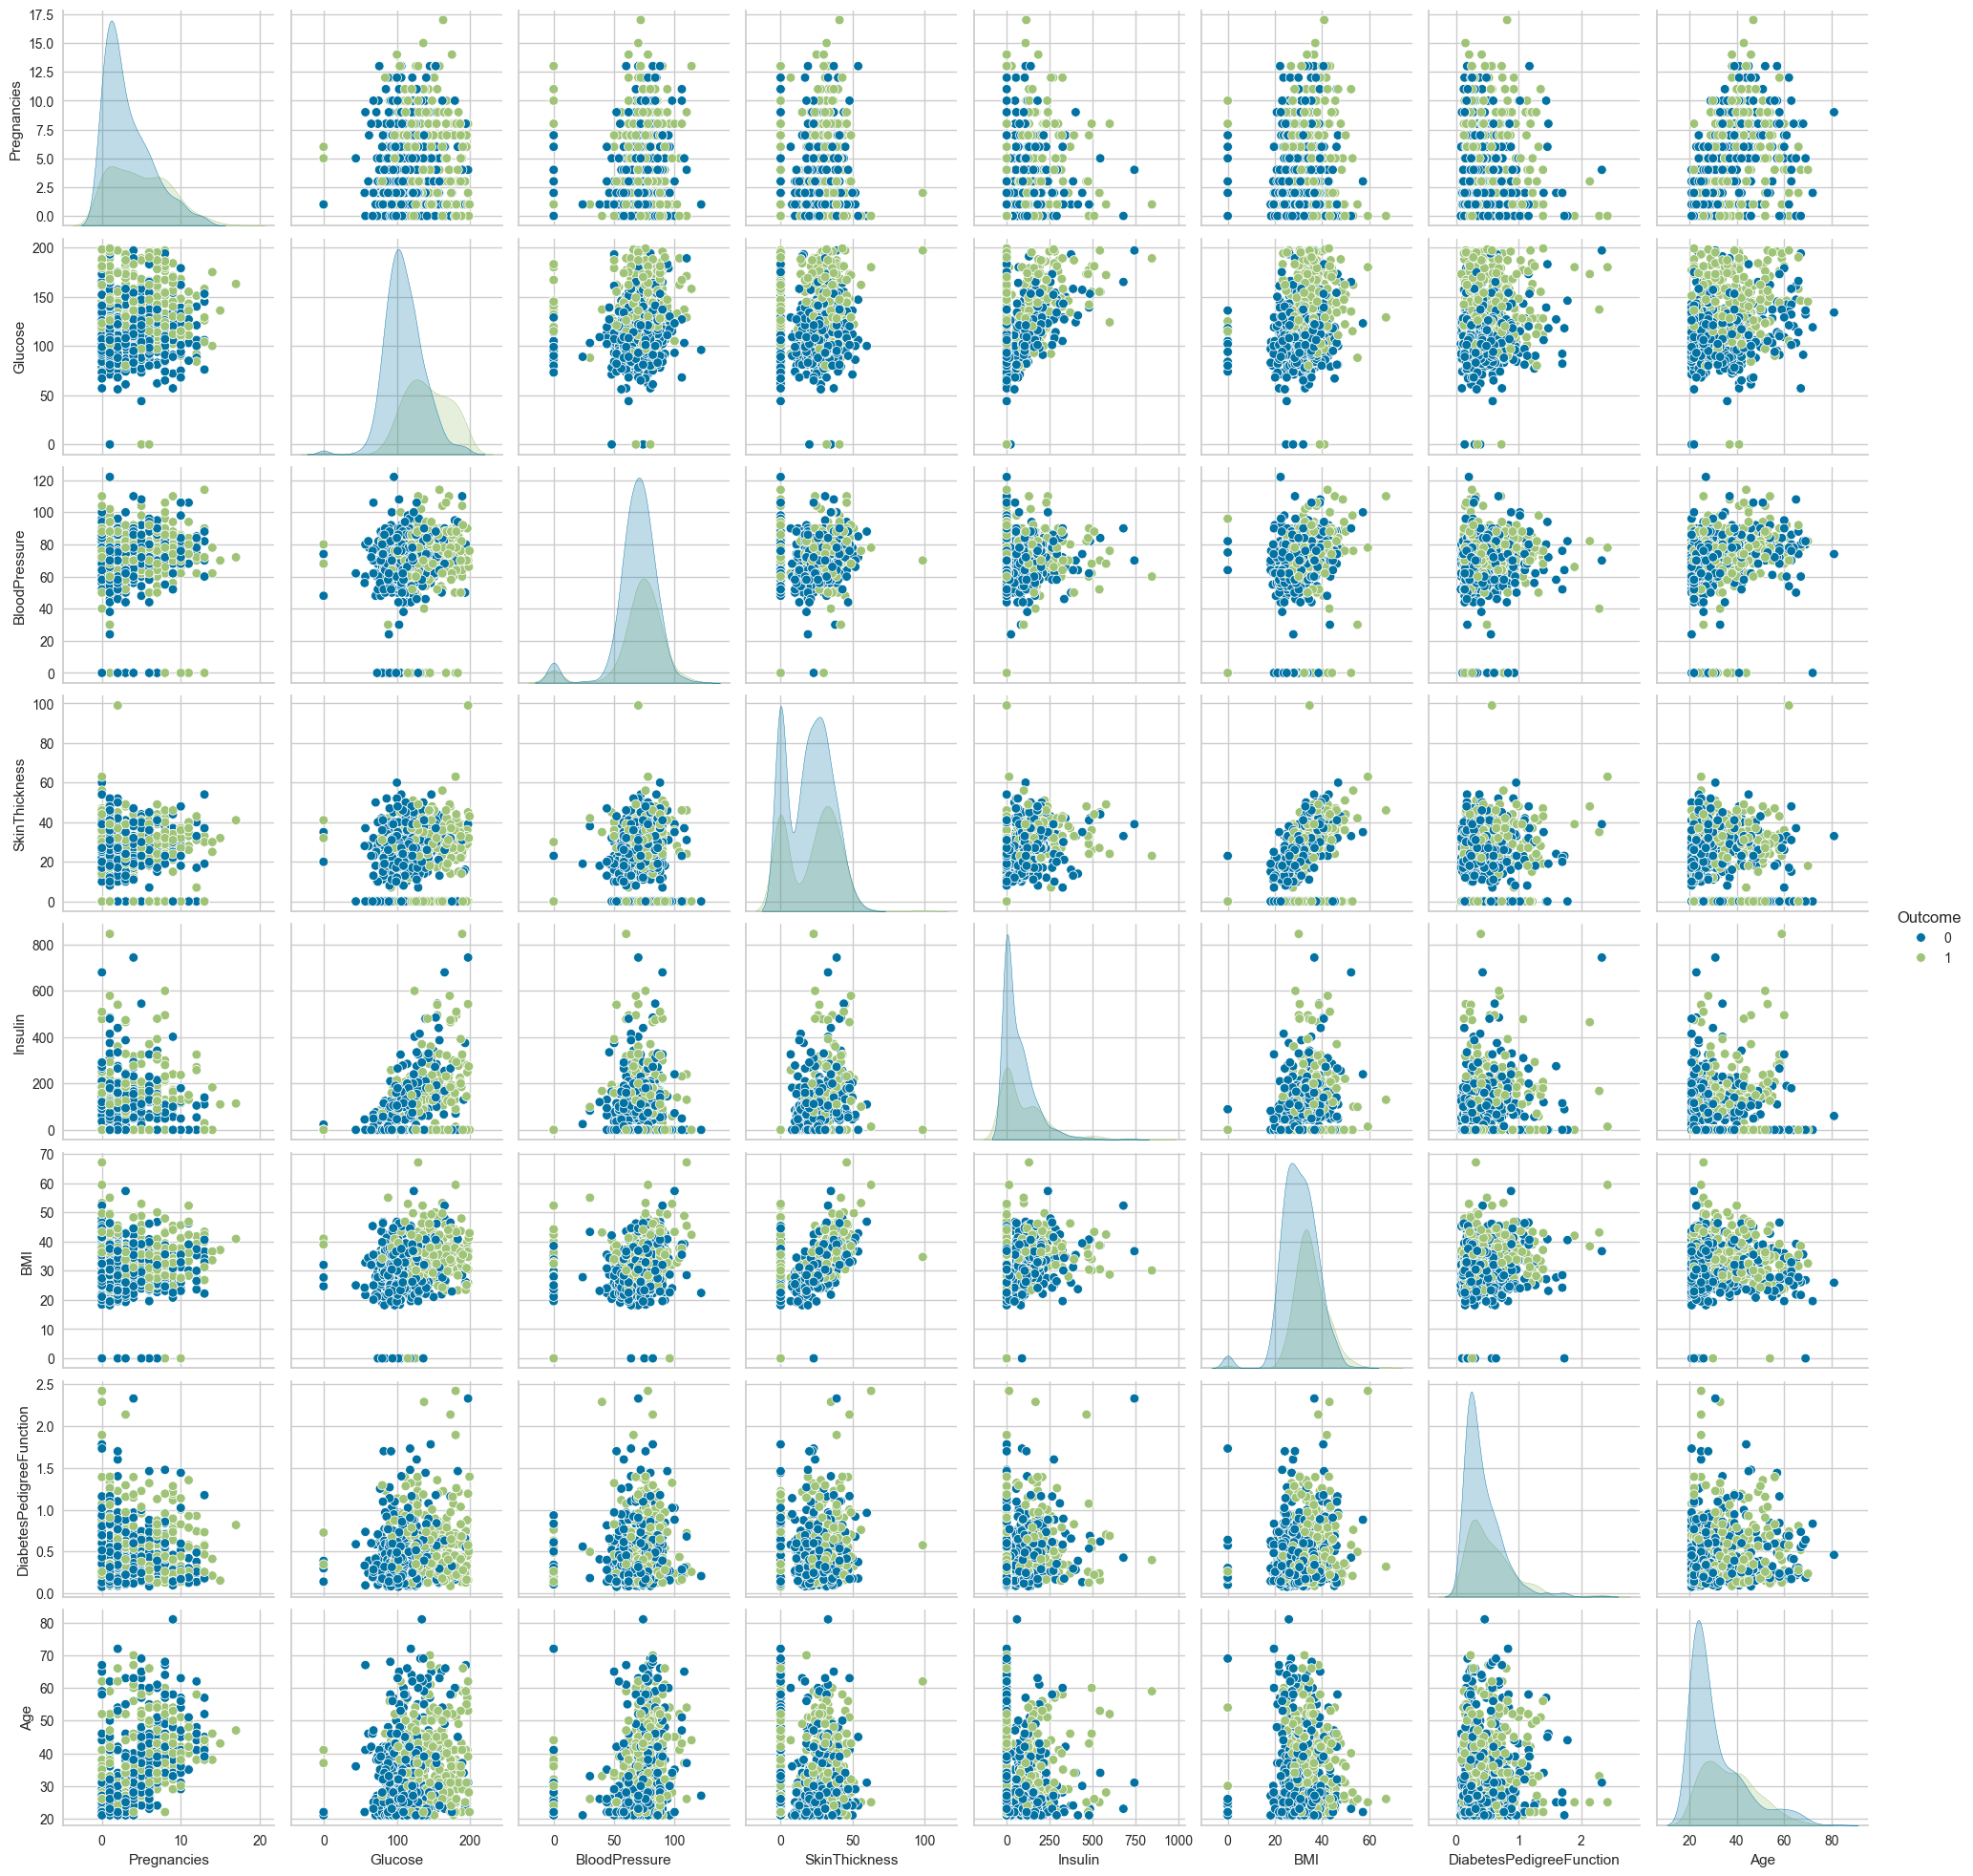

In [385]:
import seaborn as sns

sns.pairplot(df, hue='Outcome')

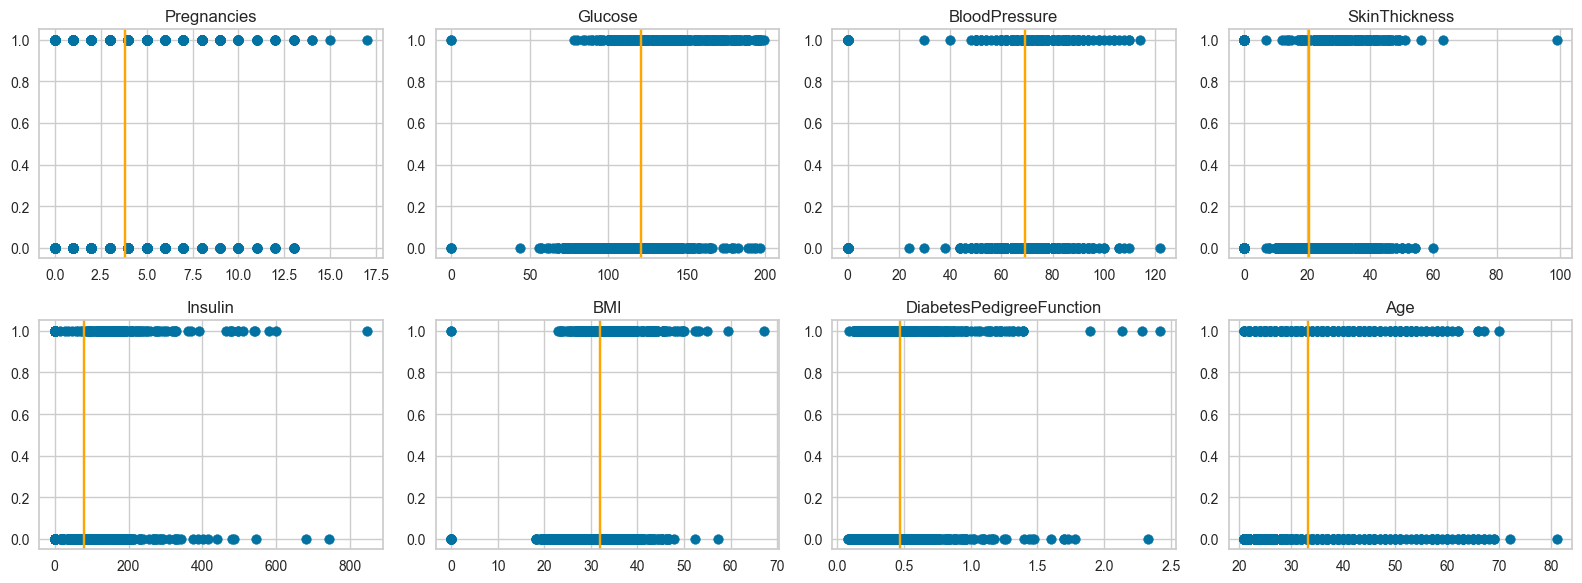

In [386]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(16, 6))
ax = ax.flatten()

for i, column in enumerate(df.columns[:-1]):
    ax[i].scatter(df[column], df['Outcome'])
    ax[i].axvline(df[column].mean(), color='orange')
    ax[i].set_title(column)

plt.tight_layout()
plt.show()

### Feature Engineering

In [387]:
size = int(len(df)*0.35)

In [388]:
#pd.crosstab(pd.qcut(df['Pregnancies'].iloc[:size], q=4, labels=False), df['Outcome'].iloc[:size])

In [389]:
cols = ['Age','BMI','DiabetesPedigreeFunction','Pregnancies']

def avoid_dl(df, cols, size, q):
    for col in cols:
        df[col + '_'], bins = pd.qcut(df[col].iloc[:size], q=q, labels=False, retbins=True)
        df.loc[size:, col + '_'] = pd.cut(df[col].iloc[size:], bins=bins, labels=False)
    return df

df = avoid_dl(df, cols, size, 4)

In [390]:
df['Pregnancies_'] = np.where(df['Pregnancies'] !=3, 1, 0)
df['BMI_'] = np.where(df['BMI'] !=3, 1, 0)
df['Age_'] = np.where(df['Age'] !=3, 1, 0)
df['DiabetesPedigreeFunction_'] = np.where(df['DiabetesPedigreeFunction'] !=3, 1, 0)


In [391]:
df['Glucose_BMI'] = df['Glucose'] / df['BMI']
df['Insulin_BMI'] = df['Insulin'] / df['BMI']
df['BloodPressure_BMI'] = df['BloodPressure'] / df['BMI']
df['Age_Pregnancies'] = df['Age'] / df['Pregnancies']

df['Insulin_Resist'] = (df['Glucose'] * df['Insulin']) / 100

df['Age_Glucose'] = df['Age'] * df['Glucose']
df['Preg_Glucose'] = df['Pregnancies'] * df['Glucose']

df["HOMA_IR"] = (df["Glucose"] * df["Insulin"]) / 405

df["HOMA_Beta"] = np.where(df["Glucose"] > 63, (360 * df["Insulin"]) / (df["Glucose"] - 63), 0)

In [392]:
df = df.replace(np.inf, 0).replace(-np.inf, 0).replace(np.nan, 0)

In [393]:
df.isna().any()

Pregnancies                  False
Glucose                      False
BloodPressure                False
SkinThickness                False
Insulin                      False
BMI                          False
DiabetesPedigreeFunction     False
Age                          False
Outcome                      False
Age_                         False
BMI_                         False
DiabetesPedigreeFunction_    False
Pregnancies_                 False
Glucose_BMI                  False
Insulin_BMI                  False
BloodPressure_BMI            False
Age_Pregnancies              False
Insulin_Resist               False
Age_Glucose                  False
Preg_Glucose                 False
HOMA_IR                      False
HOMA_Beta                    False
dtype: bool

In [394]:
# Function to replace zero values

def subs_zero(df, columns, train_size):
    for col in columns:
        for outcome_value in [0, 1]:
            subset = df.iloc[:int(len(df) * train_size)]
            sample = subset.loc[(subset['Outcome'] == outcome_value) & (subset[col] != 0), col]         
            median_val = sample.median()
            df.loc[(df['Outcome'] == outcome_value) & (df[col] == 0), col] = median_val
    return df

In [395]:
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI','Insulin_BMI','BloodPressure_BMI']
df = subs_zero(df, zero_cols, size)

In [396]:
#pd.crosstab(pd.qcut(df['Preg_Glucose'].iloc[:size], q=3, labels=False), df['Outcome'].iloc[:size])

In [397]:
cols_2 = ['Insulin_BMI','BloodPressure_BMI','Age_Glucose','Preg_Glucose']

avoid_dl(df, cols_2, size, 3)
df['Insulin_BMI_'] = np.where(df['Insulin_BMI'] !=0, 1, 0)
df['BloodPressure_BMI_'] = np.where(df['BloodPressure_BMI'] !=1, 1, 0)
df['Age_Glucose_'] = np.where(df['Age_Glucose'] !=2, 1, 0)
df['Preg_Glucose_'] = np.where(df['Preg_Glucose'] !=2, 1, 0)

### Training and normalization

In [398]:
# Splitting the data

from sklearn.model_selection import train_test_split

x = df.drop(['Outcome'], axis=1)
y = df['Outcome']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.35, random_state=42)

In [399]:
# Normalization

from sklearn.preprocessing import MinMaxScaler

num_cols = df.drop(['Outcome', 'Pregnancies_', 'BMI_', 'Age_', 'DiabetesPedigreeFunction_','Insulin_BMI_',
'BloodPressure_BMI_','Age_Glucose_','Preg_Glucose_'], axis=1).columns

scaler = MinMaxScaler()
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

In [400]:
# Setting up the models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm

lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgboost = xgb.XGBClassifier(random_state=42)
svmc = svm.SVC(probability=True, random_state=42)

In [401]:
# Training default models for the first benchmark

lr.fit(x_train,y_train)
rf.fit(x_train,y_train)
xgboost.fit(x_train,y_train)
svmc.fit(x_train,y_train)

# Getting the predictions

lr_predict = lr.predict(x_test)
rf_predict = rf.predict(x_test)
xgboost_predict = xgboost.predict(x_test)
svmc_predict = svmc.predict(x_test)

In [402]:
# Assessing the results

from sklearn.metrics import classification_report

print('Logistic Regression\n')
print(classification_report(y_test,lr_predict))
print('Random Forest\n')
print(classification_report(y_test,rf_predict))
print('Xgboost\n')
print(classification_report(y_test,xgboost_predict))
print('Support Vector Machine\n')
print(classification_report(y_test,svmc_predict))

Logistic Regression

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       322
           1       0.75      0.56      0.64       178

    accuracy                           0.78       500
   macro avg       0.77      0.73      0.74       500
weighted avg       0.77      0.78      0.77       500

Random Forest

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       322
           1       0.86      0.80      0.83       178

    accuracy                           0.88       500
   macro avg       0.87      0.86      0.87       500
weighted avg       0.88      0.88      0.88       500

Xgboost

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       322
           1       0.85      0.81      0.83       178

    accuracy                           0.88       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      

### Model optimization using GridSearchCV

In [403]:
from sklearn.model_selection import GridSearchCV

np.random.seed(seed=42)

parameters_xgboost = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'gamma': [0, 1, 5],
}


gs_xgb = GridSearchCV(xgboost, parameters_xgboost, refit=True, verbose=True, cv=5)

gs_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=True)

In [404]:
gs_xgb_predict = gs_xgb.predict(x_test)

print('Xgboost\n')
print(classification_report(y_test,gs_xgb_predict))

Xgboost

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       322
           1       0.88      0.79      0.83       178

    accuracy                           0.89       500
   macro avg       0.88      0.86      0.87       500
weighted avg       0.89      0.89      0.88       500



### Best model prediction

In [405]:
parameters_rf = {'n_estimators':[50, 100, 300, 600],
              'criterion':['gini'],
              'max_depth':[3,10,15],
              'min_samples_split':[2, 4 ,8],
              'min_samples_leaf':[2, 4 ,8]}

np.random.seed(seed=42)

rf_gs = GridSearchCV(rf, parameters_rf, refit=True, verbose=1, cv=5)

rf_gs.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [3, 10, 15],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [50, 100, 300, 600]},
             verbose=1)

In [406]:
rf_gs_predict = rf_gs.predict(x_test)

print('Random Forest\n')
print(classification_report(y_test,rf_gs_predict))

Random Forest

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       322
           1       0.86      0.81      0.83       178

    accuracy                           0.88       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.88      0.88       500

